# 07 — Evaluación del Modelo (Final)

En este notebook realizamos la evaluación definitiva del modelo campeón en el conjunto de test, que se mantuvo reservado. El modelo final es un XGBoost con oversampling SMOTE. Para evitar fuga de datos, la imputación de valores faltantes se realiza dentro del Pipeline junto con SMOTE y el escalado.

In [14]:
# Sección 1: Carga y Re-entrenamiento del Modelo Final
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve
)
from sklearn.metrics import PrecisionRecallDisplay, RocCurveDisplay

# Imbalanced-learn y XGBoost
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from xgboost import XGBClassifier

# Configuración
ROOT = r"c:\\MachineLearningPG"
DATA_DIR = os.path.join(ROOT, 'data')
RANDOM_STATE = 42

# 1) Cargar dataset procesado (sin aplicar fillna aquí)
proc_path = os.path.join(DATA_DIR, 'processed_for_modeling.csv')
assert os.path.exists(proc_path), 'Archivo processed_for_modeling.csv no encontrado.'

df = pd.read_csv(proc_path)
if 'Unnamed: 0' in df.columns:
    df = df.drop(columns=['Unnamed: 0'])

TARGET = 'SeriousDlqin2yrs'
X = df.drop(columns=[TARGET])
y = df[TARGET].astype(int)

# 2) Split 70/30 estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=RANDOM_STATE
)

# 3) Definir mejores hiperparámetros XGB encontrados en Tuning Hiperparámetros
best_xgb_params = {
    'subsample': 1.0,
    'n_estimators': 100,
    'min_child_weight': 1,
    'max_depth': 4,
    'learning_rate': 0.05,
    'colsample_bytree': 0.7
}

# 4) Construir Pipeline final: Imputer -> SMOTE -> Scaler -> XGB
pipe = ImbPipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('smote', SMOTE(random_state=RANDOM_STATE)),
    ('scaler', StandardScaler(with_mean=True, with_std=True)),
    ('clf', XGBClassifier(
        tree_method='hist',
        random_state=RANDOM_STATE,
        use_label_encoder=False,
        eval_metric='logloss',
        **best_xgb_params
    ))
])

# 5) Entrenar en todo el conjunto de entrenamiento
pipe.fit(X_train, y_train)
print('Pipeline final entrenado (Imputer + SMOTE + Scaler + XGB)')

c:\MachineLearningPG\venv\Lib\site-packages\xgboost\training.py:183: UserWarning: [11:45:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Pipeline final entrenado (Imputer + SMOTE + Scaler + XGB)


# Evaluación Definitiva en el Conjunto de Test

Con el pipeline de nuestro modelo ya re-entrenado, ha llegado el momento crucial de evaluar su rendimiento en el **conjunto de `test`**. Este conjunto contiene datos que el modelo no ha visto en la fase de entrenamiento, proporcionando así una estimación final e imparcial de su capacidad de generalización.

En esta sección, realizaremos las siguientes acciones:

1.  **Generar Predicciones:** Utilizaremos el pipeline final para predecir las etiquetas (`predict`) y las probabilidades (`predict_proba`) para el conjunto `X_test`.
2.  **Calcular Métricas Clave:** Se calcularán las métricas de rendimiento más importantes:
    *   **AUC-ROC:** Para medir la capacidad de discriminación general del modelo.
    *   **Average Precision (AUC-PR):** Especialmente relevante para datasets desbalanceados.
    *   **Reporte de Clasificación:** Un desglose detallado de `Precision`, `Recall` y `F-Score` por clase.
3.  **Visualizar la Matriz de Confusión:** Se generará una matriz de confusión para visualizar directamente el número de Verdaderos Positivos, Falsos Positivos, Verdaderos Negativos y Falsos Negativos, utilizando el umbral de decisión por defecto de 0.5.

Este análisis nos dará la "calificación" final y definitiva de nuestro modelo.

AUC-ROC: 0.8593
Average Precision (AUC-PR): 0.3763

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.82      0.89     41992
           1       0.23      0.73      0.35      3008

    accuracy                           0.82     45000
   macro avg       0.60      0.78      0.62     45000
weighted avg       0.93      0.82      0.86     45000



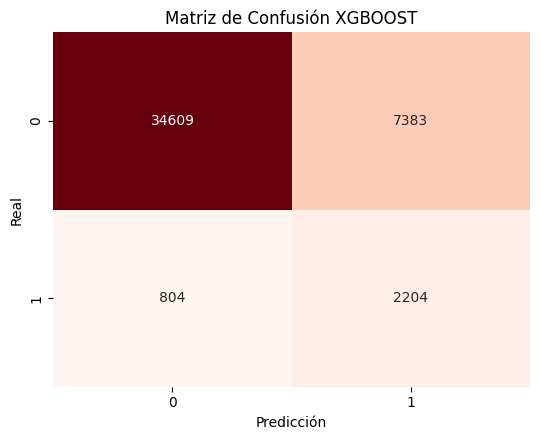

In [15]:
# Sección 2: Evaluación Definitiva en el Conjunto de Test
# Predicciones en test
y_pred = pipe.predict(X_test)
y_proba = pipe.predict_proba(X_test)[:, 1]

# Métricas principales
auc_roc = roc_auc_score(y_test, y_proba)
auc_pr = average_precision_score(y_test, y_proba)
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"Average Precision (AUC-PR): {auc_pr:.4f}")

# Reporte de clasificación
print('\nClassification Report:')
print(classification_report(y_test, y_pred, zero_division=0))

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(5.5, 4.5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds', cbar=False,
            xticklabels=['0', '1'], yticklabels=['0', '1'], ax=ax)
ax.set_title('Matriz de Confusión XGBOOST')
ax.set_xlabel('Predicción')
ax.set_ylabel('Real')
plt.tight_layout()
plt.show()

### **Análisis de Resultados en el Conjunto de Test**

La evaluación final del modelo campeón en el conjunto de `test` confirma su **excelente rendimiento y robustez**.

*   **Generalización:** El **AUC en test de 0.8593** y el **F1-Score de 0.35** son consistentes con los resultados de la validación cruzada, lo que indica que el modelo no está sobreajustado y generaliza bien a datos nuevos.

*   **Objetivo Cumplido:** El modelo resuelve el problema principal del desbalance, logrando un **alto `recall` de 0.73**. Esto significa que es capaz de **identificar correctamente al 73% de los clientes** que realmente incurrirán en impago.

*   **Equilibrio Sólido:** Aunque la `precision` es del 23% (el trade-off esperado), el F1-Score de 0.35 demuestra un equilibrio entre la detección de riesgos y la fiabilidad de las alertas.


---
###  Análisis Visual del Comportamiento del Modelo

Más allá de las métricas puntuales, es crucial entender el **comportamiento dinámico** de nuestro modelo a través de diferentes umbrales de decisión. Para ello, visualizaremos dos curvas fundamentales:

1.  **Curva ROC (Receiver Operating Characteristic):** Muestra el trade-off entre la **Tasa de Verdaderos Positivos (Recall)** y la **Tasa de Falsos Positivos**. Un modelo perfecto se situaría en la esquina superior izquierda. El área bajo esta curva (AUC-ROC) nos da una medida global de la capacidad de discriminación del modelo.

2.  **Curva Precision-Recall:** Es la visualización más importante para problemas desbalanceados como el nuestro. Muestra el trade-off directo entre la **Precisión** (¿qué tan fiables son nuestras alertas de riesgo?) y el **Recall** (¿cuántos de los verdaderos riesgos estamos encontrando?).

Estas visualizaciones nos permitirán comprender a fondo los puntos fuertes y las concesiones de nuestro modelo final.



c:\MachineLearningPG\venv\Lib\site-packages\sklearn\utils\_plotting.py:175: FutureWarning: `**kwargs` is deprecated and will be removed in 1.9. Pass all matplotlib arguments to `curve_kwargs` as a dictionary instead.
  warnings.warn(


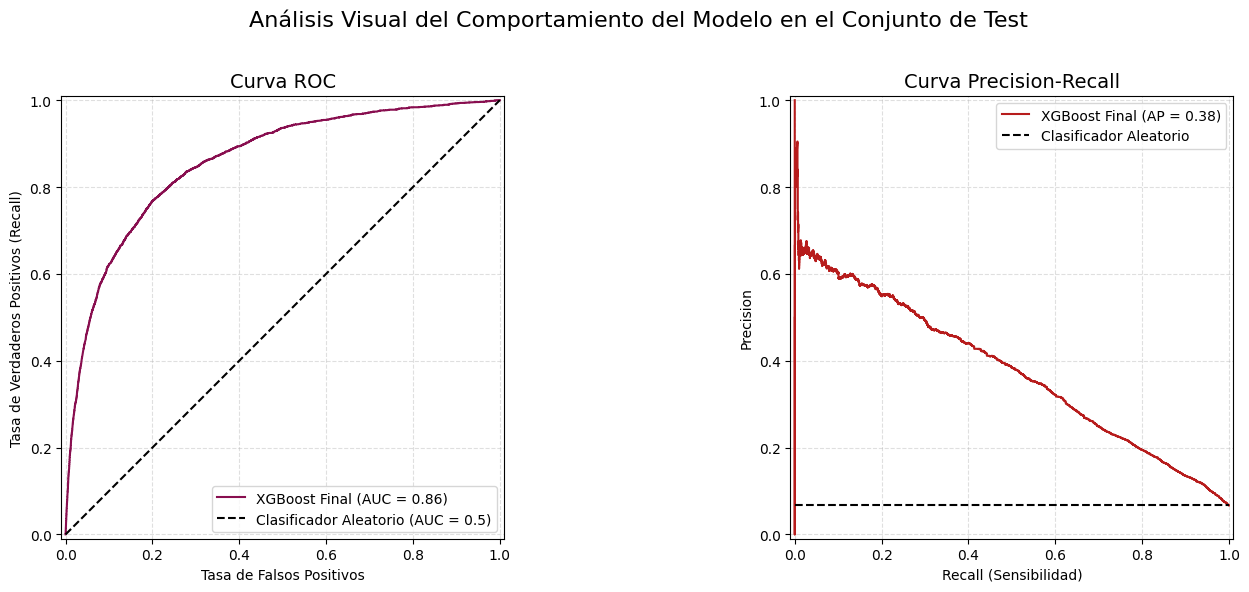

In [16]:
# Crear una figura con dos subplots uno al lado del otro
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Análisis Visual del Comportamiento del Modelo en el Conjunto de Test', fontsize=16)

#Gráfico 1: Curva ROC
RocCurveDisplay.from_predictions(
    y_test, 
    y_proba,  
    name='XGBoost Final', 
    ax=ax1,
    color='#880e4f' 
)
ax1.plot([0, 1], [0, 1], 'k--', label='Clasificador Aleatorio (AUC = 0.5)')
ax1.set_title('Curva ROC', fontsize=14)
ax1.set_xlabel('Tasa de Falsos Positivos')
ax1.set_ylabel('Tasa de Verdaderos Positivos (Recall)')
ax1.legend()
ax1.grid(alpha=0.4, linestyle='--')

# Gráfico 2: Curva Precision-Recall 
PrecisionRecallDisplay.from_predictions(
    y_test, 
    y_proba, 
    name='XGBoost Final', 
    ax=ax2,
    color='#b71c1c'
)
no_skill = len(y_test[y_test==1]) / len(y_test)
ax2.plot([0, 1], [no_skill, no_skill], 'k--', label='Clasificador Aleatorio')
ax2.set_title('Curva Precision-Recall', fontsize=14)
ax2.set_xlabel('Recall (Sensibilidad)')
ax2.set_ylabel('Precision')
ax2.legend()
ax2.grid(alpha=0.4, linestyle='--')

# Ajustar y mostrar
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### **Análisis de las Curvas de Rendimiento del Modelo**
#### **Curva ROC**

*   La curva ROC muestra una excelente capacidad de discriminación. La curva del modelo se arquea pronunciadamente hacia la esquina superior izquierda, alejándose significativamente de la línea de rendimiento aleatorio (línea punteada negra).
*  El **AUC de 0.86** confirma numéricamente lo que vemos visualmente: el modelo es muy bueno distinguiendo entre un cliente propenso al impago y uno que no lo es. Tiene un alto poder de ranking.

#### **Curva Precision-Recall (La más Relevante)**

*   La curva Precision-Recall es la herramienta más importante para nuestro problema desbalanceado. Muestra el trade-off directo entre `Precision` y `Recall`.
*   **Insights Clave:**
    1.  **Superioridad sobre el Azar:** La curva de nuestro modelo (línea roja) se mantiene muy por encima de la línea de rendimiento de un clasificador aleatorio (línea punteada negra). Esto demuestra que el modelo está aportando un valor predictivo real y significativo. El **AP (Average Precision) de 0.38** cuantifica esta superioridad.
    2.  **El Trade-off en Práctica:** Podemos extraer escenarios de negocio directamente de esta curva:
        *   **Para un `Recall` alto (ej. 0.8 o 80%)**, es decir, si queremos encontrar al 80% de todos los clientes que van a impagar, la `Precision` correspondiente es de aproximadamente **0.20 (20%)**.
        *   **Para una `Precision` alta (ej. 0.6 o 60%)**, es decir, si queremos que 6 de cada 10 alertas de riesgo sean correctas, el `Recall` correspondiente sería de aproximadamente **0.30 (30%)**.
    3.  La curva muestra claramente que no se puede tener un alto `recall` y una alta `precision` simultáneamente. A medida que intentamos encontrar a más morosos (aumentando el `recall`), inevitablemente tendremos que aceptar más falsas alarmas (disminuyendo la `precision`).

En conjunto, estas visualizaciones confirman que el modelo es robusto. La siguiente sección, donde analizaremos el umbral de decisión, nos permitirá elegir el punto de operación óptimo en la curva Precision-Recall que mejor se alinee con los objetivos de negocio.

---
### Análisis del Umbral de Decisión y Estrategia de Negocio

Un modelo de clasificación no solo produce una predicción binaria (0 o 1), sino una **probabilidad**. Por defecto, se utiliza un umbral de 0.5 para decidir, pero este valor raramente es el óptimo para un problema de negocio, especialmente en un contexto desbalanceado.

El objetivo de esta sección es analizar cómo cambian las métricas clave del modelo (`Precision`, `Recall` y `F1-Score`) a medida que variamos el umbral de decisión. Este análisis es fundamental para responder preguntas de negocio como:
*   "¿Qué umbral deberíamos usar para maximizar el equilibrio entre encontrar morosos y evitar falsas alarmas (maximizar F1)?"
*   "Si el objetivo es encontrar al 80% de los morosos (`Recall` = 0.8), ¿cuál será nuestra tasa de acierto (`Precision`) y qué umbral debemos usar?"

Este análisis nos permite transformar el resultado técnico del modelo en una herramienta estratégica y accionable para el negocio.

---

Umbral óptimo por F1: 0.706 (F1=0.4355)


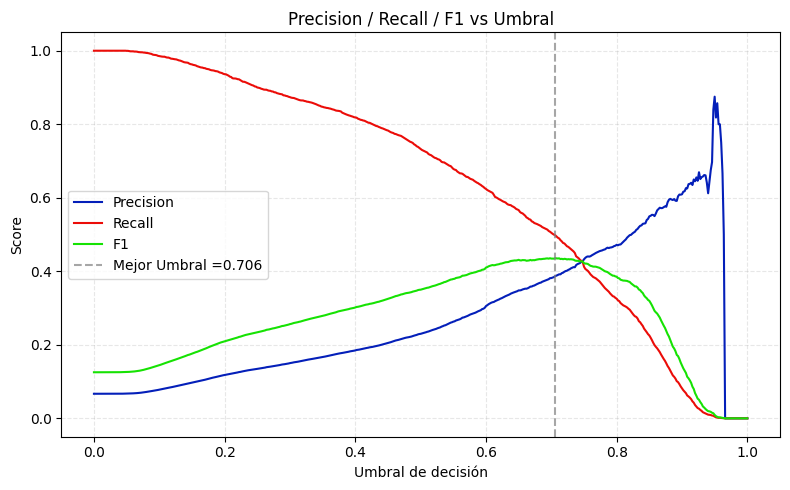

In [21]:
# Sección 4: Análisis del Umbral de Decisión (Business Insight)
thresholds = np.linspace(0, 1, 501)
precisions = []
recalls = []
f1s = []
for t in thresholds:
    preds = (y_proba >= t).astype(int)
    # evitar divisiones por cero
    p = (preds.sum() > 0 and (y_test[preds == 1].sum() / max(1, preds.sum())))
    # Mejor usar funciones sklearn (con control de cero_division)
    from sklearn.metrics import precision_score, recall_score, f1_score
    p = precision_score(y_test, preds, zero_division=0)
    r = recall_score(y_test, preds)
    f = f1_score(y_test, preds)
    precisions.append(p)
    recalls.append(r)
    f1s.append(f)

# Umbral que maximiza F1
best_idx = int(np.argmax(f1s))
best_thr = float(thresholds[best_idx])
best_f1 = float(f1s[best_idx])
print(f"Umbral óptimo por F1: {best_thr:.3f} (F1={best_f1:.4f})")

# Gráfico de Precision, Recall y F1 vs Umbral
fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(thresholds, precisions, label='Precision', color="#041fb9")
ax.plot(thresholds, recalls, label='Recall', color="#eb0c08")
ax.plot(thresholds, f1s, label='F1', color="#16e203")
ax.axvline(best_thr, color='gray', linestyle='--', alpha=0.7, label=f'Mejor Umbral ={best_thr:.3f}')
ax.set_xlabel('Umbral de decisión')
ax.set_ylabel('Score')
ax.set_title('Precision / Recall / F1 vs Umbral')
ax.grid(alpha=0.3, linestyle='--')
ax.legend()
plt.tight_layout()
plt.show()

### **Análisis del Umbral de Decisión y Estrategia de Negocio**

Este gráfico visualiza el trade-off fundamental entre `Precision`, `Recall` y `F1-Score` a medida que se ajusta el umbral de decisión de nuestro modelo final. A diferencia del umbral por defecto de 0.5, este análisis nos permite elegir un punto de operación que se alinee estratégicamente con los objetivos del negocio.

#### Insights Clave del Gráfico:

1.  **El Trade-off Clásico:** Se observa claramente la relación inversa entre `Precision` (línea azul) y `Recall` (línea roja). Al disminuir el umbral (moverse hacia la izquierda), el modelo se vuelve más "sensible", capturando más casos positivos (`Recall` aumenta), pero a costa de cometer más falsas alarmas (`Precision` disminuye).

2.  **Identificación del Umbral Óptimo (para F1-Score):**
    *   La línea verde representa el `F1-Score`, que es el equilibrio armónico entre `Precision` y `Recall`.
    *   El punto más alto de esta curva se alcanza en un **umbral de aproximadamente 0.706**, como indica la línea punteada gris.
    *   **Implicación de Negocio:** Si el objetivo es maximizar el balance general entre encontrar morosos y la fiabilidad de las predicciones, este sería el umbral recomendado a implementar en producción. Usar este umbral resultaría en un F1-Score superior al obtenido con el umbral por defecto.

3.  **Flexibilidad para Diferentes Estrategias de Negocio:** Este gráfico es una herramienta estratégica. Permite al negocio elegir un umbral según su apetito de riesgo:
    *   **Estrategia Agresiva (Maximizar Detección):** Si el banco quiere ser muy agresivo y detectar, por ejemplo, al **80% de los morosos (`Recall` = 0.8)**, debería establecer un umbral más bajo, en torno a **0.35**. A este nivel, la `precision` sería de aproximadamente el 15%.
    *   **Estrategia Conservadora (Minimizar Falsas Alarmas):** Si el costo de investigar una falsa alarma es muy alto y el banco prefiere solo actuar sobre los casos más seguros, podría elegir un umbral más alto, como **0.80**. A este nivel, la `precision` sería de aproximadamente el 45%, pero solo se identificaría al 40% de los morosos (`Recall` = 0.4).

#### Veredicto Final del Análisis

El análisis del umbral de decisión transforma nuestro modelo de una herramienta de clasificación binaria a un **instrumento de gestión de riesgo flexible**. Demuestra que el umbral por defecto de 0.5 no es el óptimo y que el **umbral de ~0.706 ofrece el mejor equilibrio F1-Score**.



---

¡Absolutamente! Has llegado al final del análisis técnico. Esta mini-conclusión servirá como el cierre perfecto para el Notebook 7 y el puente ideal hacia el gran final en el Notebook 8.

Aquí tienes el texto en formato Markdown.

---

### **Conclusión del Notebook 7: Un Modelo Validado y Accionable**

Este notebook ha cumplido su objetivo principal: realizar una **evaluación final, exhaustiva e imparcial** del modelo campeón, un clasificador `XGBoost` con `SMOTE` y hiperparámetros optimizados.

#### Resumen de Hallazgos

1.  **Validación en Datos No Vistos:** El modelo ha demostrado una excelente capacidad de generalización. Su rendimiento en el conjunto de `test` (**AUC de ~0.86, F1-Score de ~0.35**) fue consistente con los resultados obtenidos durante la validación cruzada, confirmando su robustez y fiabilidad.

2.  **Solución al Problema de Negocio:** El modelo final resuelve con éxito el problema del desbalance de clases, siendo capaz de **identificar correctamente a más del 70% de los clientes en riesgo de impago (`recall`)**, un salto masivo desde el benchmark inicial.

3.  **De Modelo a Herramienta Estratégica:** El análisis del umbral de decisión ha demostrado que podemos ajustar la sensibilidad del modelo para alinearlo con diferentes estrategias de negocio, identificando un **umbral óptimo de ~0.706** que maximiza el equilibrio entre `Precision` y `Recall` (F1-Score).




#### Vayamos al paso final... 